In [ ]:
# enable autoreload
%load_ext autoreload
%autoreload 2

import sys, os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from monai.losses import DiceCELoss

# include project src in path
sys.path.append(os.path.abspath("src"))
from inference import run_inference, evaluate, evaluate_predictions
from monai.losses import DiceCELoss
from utils_visualization import visualize_slices


/home/herminea/.local/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-04-20 11:42:22.730057: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 11:42:23.009765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available

In [2]:
# set parameters
DATA_DIR       = "/datasets/tdt4265/mic/open/HNTS-MRG"
CHECKPOINT     = "results/exp23_nnunet/checkpoints/best.ckpt"
OUTPUT_DIR     = "results/inference"
BATCH_SIZE     = 3
MODEL_TYPE     = "nnunet"
DEVICE         = torch.device("cuda:0")      

# run inference and grab model + loader
model, test_loader = run_inference(
    data_dir   = DATA_DIR,
    checkpoint = CHECKPOINT,
    output_dir = OUTPUT_DIR,
    batch_size = BATCH_SIZE,
    model_type = MODEL_TYPE,
    device     = DEVICE,
    save_labels= True,
)

`len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Loading dataset: 100%|██████████| 20/20 [00:12<00:00,  1.63it

Inference done; outputs in results/inference


In [3]:
loss_fn = DiceCELoss(
    to_onehot_y=True, softmax=True,
    weight=torch.tensor([0.4,1.7,1.5]).to(DEVICE),
    lambda_dice=0.7, lambda_ce=0.3
)

# evaluate the model on the test set
metrics = evaluate(
    model=model,
    dataloader=test_loader,
    loss_criterion=loss_fn, 
    device=DEVICE
)

# print the metrics
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")



nll_loss2d_forward_out_cuda_template does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:83.)


avg_loss: 0.4472
mean_dice: 0.5229
dice_class1: 0.4749
dice_class2: 0.5708
prec_class1: 0.7043
recall_class1: 0.6249
prec_class2: 0.7219
recall_class2: 0.5860


Label class distribution: (1751331, 0, 18141)
Prediction class distribution: (1753443, 614, 15415)


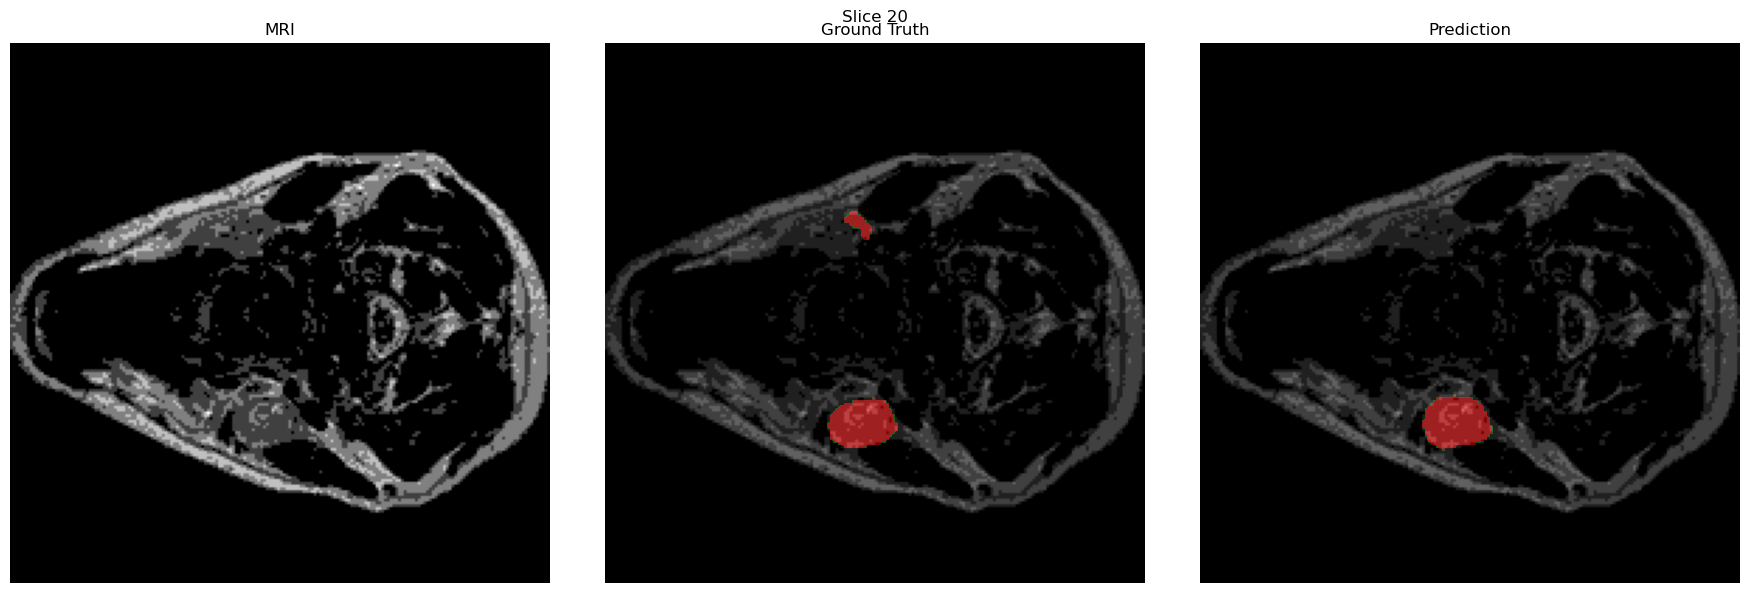

In [6]:
### VISUALIZE SLICES ###
visualize_slices(
    image_path     = f"{OUTPUT_DIR}/image_16.nii.gz",
    label_path     = f"{OUTPUT_DIR}/label_16.nii.gz",
    prediction_path= f"{OUTPUT_DIR}/prediction_16.nii.gz",
    slice_idx      = 20
)


In [ ]:
# directory where ensemble_inference.py saved the flat NIfTIs
OUTPUT_DIR = "results/ensemble_predictions"
evaluate_predictions(OUTPUT_DIR)